In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
def financial_ratios(ticker):
    stock = yf.download(tickers=ticker, auto_adjust=True)
    apikey = '3WZH46PUYUQ32UBX'
    url_IS = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={ticker}&apikey={apikey}'
    url_BS = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={ticker}&apikey={apikey}'
    url_CF = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={ticker}&apikey={apikey}'

    r_IS = requests.get(url=url_IS)
    r_BS = requests.get(url=url_BS)
    r_CF = requests.get(url=url_CF)
    js_IS = r_IS.json()['annualReports']
    js_BS = r_BS.json()['annualReports']
    js_CF = r_CF.json()['annualReports']
    df_IS = pd.DataFrame(js_IS)
    df_BS = pd.DataFrame(js_BS)
    df_CF = pd.DataFrame(js_CF)
    data = pd.concat([df_IS, df_BS, df_CF], axis=1)
    data = data.T.drop_duplicates(keep='last').T
    data['fiscalDateEnding'] = pd.to_datetime(data['fiscalDateEnding'], format='%Y/%m/%d')
    data.set_index(data['fiscalDateEnding'], inplace=True)
    data.sort_index(ascending=True, inplace=True)
    data.drop(columns=['fiscalDateEnding', 'reportedCurrency'], inplace=True)
    data = data.replace('None', 0)
    data = data.astype(float)
    financial_data = data.join(stock['Close'], how='inner')
    financial_data.rename(columns={'Close': 'price'}, inplace=True)
    return financial_data

In [3]:
data = financial_ratios('AAPL')
data

[*********************100%***********************]  1 of 1 completed


,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,netInterestIncome,...,proceedsFromRepaymentsOfShortTermDebt,paymentsForRepurchaseOfEquity,dividendPayoutCommonStock,proceedsFromIssuanceOfCommonStock,proceedsFromIssuanceOfLongTermDebtAndCapitalSecuritiesNet,proceedsFromRepurchaseOfEquity,changeInCashAndCashEquivalents,changeInExchangeRate,netIncome,price
2019-09-30,9.839200e+10,2.565980e+11,1.800270e+11,1.617820e+11,6.393000e+10,1.824500e+10,1.621700e+10,3.446200e+10,4.961000e+09,-3.576000e+09,...,-1.195400e+10,6.689700e+10,1.411900e+10,7.810000e+08,6.963000e+09,-6.611600e+10,2.431100e+10,0.0,5.525600e+10,54.607025
2020-09-30,1.049560e+11,2.716420e+11,1.894750e+11,1.695590e+11,6.628800e+10,1.991600e+10,1.875200e+10,3.866800e+10,3.763000e+09,-2.873000e+09,...,-1.926000e+09,7.235800e+10,1.408100e+10,8.800000e+08,1.609100e+10,-7.147800e+10,-1.043500e+10,0.0,5.741100e+10,114.065025
2021-09-30,1.528360e+11,3.631720e+11,2.349540e+11,2.129810e+11,1.089490e+11,2.197300e+10,2.191400e+10,4.388700e+10,2.843000e+09,-2.645000e+09,...,2.044000e+09,8.597100e+10,1.446700e+10,1.105000e+09,2.039300e+10,-8.486600e+10,-3.860000e+09,0.0,9.468000e+10,140.264328
2022-09-30,1.707820e+11,3.913970e+11,2.486400e+11,2.235460e+11,1.194370e+11,2.509400e+10,2.625100e+10,5.134500e+10,2.825000e+09,-2.931000e+09,...,7.910000e+09,8.940200e+10,1.484100e+10,0.000000e+00,5.465000e+09,-8.940200e+10,-1.095200e+10,0.0,9.980300e+10,137.760773


In [4]:
ratios = data.loc[:, ['totalCurrentAssets', 'totalCurrentLiabilities', 'inventory', 'netIncome', 'commonStockSharesOutstanding', 'price', 'totalLiabilities', 'totalShareholderEquity']]
ratios['working_capital'] = round((ratios['totalCurrentAssets'] - ratios['totalCurrentLiabilities']) / 1_000_000, 2)
ratios['acid_test'] = round((ratios['totalCurrentAssets'] - ratios['inventory']) / 1_000_000, 2)
ratios['eps'] = round((ratios['netIncome'] / ratios['commonStockSharesOutstanding']) * 100, 2)
ratios['p/e'] = round((ratios['price'] / ratios['eps']) * 100, 2)
ratios['debt_to_equity_ratio'] = round((ratios['totalLiabilities'] / ratios['totalShareholderEquity']) * 100, 2)
ratios['roe'] = round((ratios['netIncome'] / ratios['totalShareholderEquity']) * 100, 2)
ratios = ratios.iloc[:, 8:]
ratios

,working_capital,acid_test,eps,p/e,debt_to_equity_ratio,roe
2019-09-30,57101.0,158713.0,1243.60,4.39,274.10,61.06
2020-09-30,38321.0,139652.0,338.17,33.73,395.70,87.87
2021-09-30,9355.0,128256.0,576.38,24.34,456.35,150.07
2022-09-30,-18577.0,130459.0,625.98,22.01,596.15,196.96


C:\Users\caser\AppData\Local\Temp/ipykernel_11592/717643272.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ratios.index.date, rotation=45, ha='right')
C:\Users\caser\AppData\Local\Temp/ipykernel_11592/717643272.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ratios.index.date, rotation=45, ha='right')
C:\Users\caser\AppData\Local\Temp/ipykernel_11592/717643272.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ratios.index.date, rotation=45, ha='right')
C:\Users\caser\AppData\Local\Temp/ipykernel_11592/717643272.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ratios.index.date, rotation=45, ha='right')
C:\Users\caser\AppData\Local\Temp/ipykernel_11592/717643272.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ratios.index.d

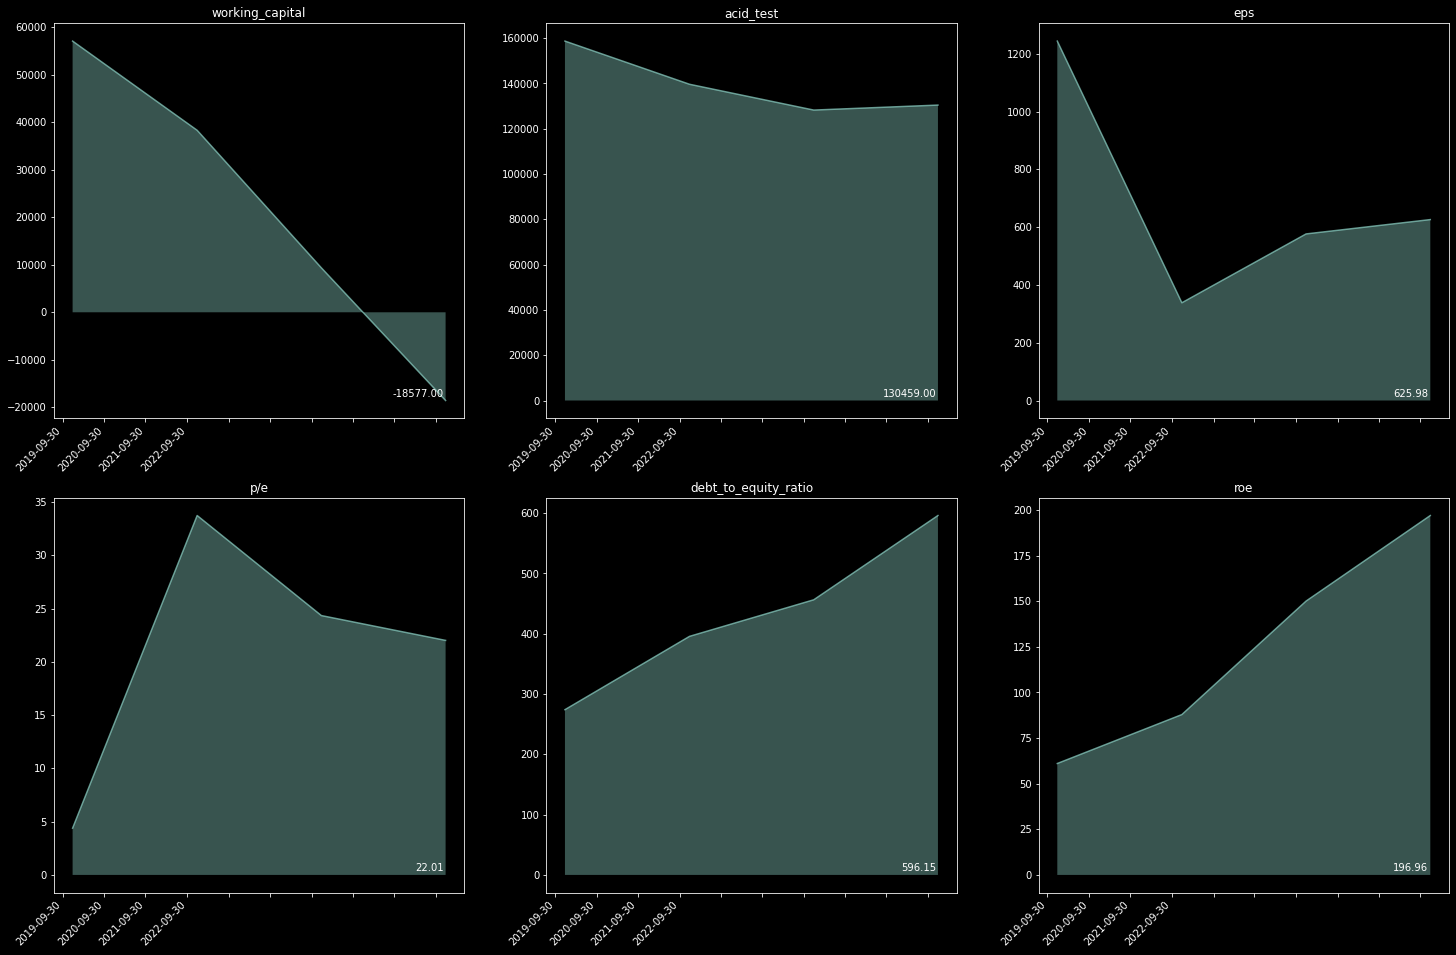

In [5]:
plt.style.use('dark_background')
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 16))
cols = ratios.columns
for i, ax in enumerate(ax.flatten()):
    if i < len(cols):
        ax.plot(ratios.index.date, ratios[cols[i]], alpha=0.7)
        ax.fill_between(ratios.index.date, ratios[cols[i]], alpha=0.4)
        ax.set_title(cols[i])
        ax.set_xticklabels(ratios.index.date, rotation=45, ha='right')
        ax.text(0.95, 0.05, f"{ratios[cols[i]].iloc[-1]:.2f}", transform=ax.transAxes, horizontalalignment='right', verticalalignment='bottom')
    else:
        fig.delaxes(ax)